# NovaCred — Bias Detection & Fairness Analysis

**Role:** Data Scientist  
**Inputs:** `applications_analysis.csv`, `spending_items_clean.csv`  
**Source module:** `src/bias.py`

Covers:
1. Gender disparate impact (four-fifths rule)
2. Age-based bias patterns
3. Gender × age interaction effects
4. Proxy discrimination (financial features + spending categories)
5. Interest rate disparity (approved applicants)
6. Rejection reason breakdown
7. Fairness summary export

## Setup

In [1]:
from pathlib import Path
import sys
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import src.bias as bias

pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 30)

FIGURES_DIR = PROJECT_ROOT / 'figures'
QUALITY_DIR = PROJECT_ROOT / 'data' / 'quality'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
QUALITY_DIR.mkdir(parents=True, exist_ok=True)

## 1. Load Data

This step establishes the analytical starting point for the bias assessment. We load the PII-safe analysis dataset produced by the data engineering pipeline: one canonical row per application, with direct identifiers removed and age represented as a coarse band. The spending table is loaded separately and will be joined later only for the proxy discrimination analysis. Records with missing outcomes or missing group membership are excluded from each analysis individually and the exclusion count is reported, so the scope of every metric is transparent.

In [2]:
analysis = bias.load_analysis(PROJECT_ROOT / 'data' / 'curated' / 'applications_analysis.csv')
spending = bias.load_spending(PROJECT_ROOT / 'data' / 'curated' / 'spending_items_clean.csv')

print(f'Analysis dataset : {analysis.shape[0]:,} rows x {analysis.shape[1]} columns')
print(f'Spending dataset : {spending.shape[0]:,} rows x {spending.shape[1]} columns')
print()
print('Outcome distribution:')
print(analysis['clean_loan_approved'].value_counts(dropna=False))
print()
print('Gender distribution:')
print(analysis['clean_gender'].value_counts(dropna=False))
print()
print('Age band distribution:')
print(analysis['age_band'].value_counts(dropna=False).sort_index())

Analysis dataset : 500 rows x 17 columns
Spending dataset : 827 rows x 10 columns

Outcome distribution:
clean_loan_approved
True     292
False    208
Name: count, dtype: int64

Gender distribution:
clean_gender
Female    250
Male      247
NaN         3
Name: count, dtype: int64

Age band distribution:
age_band
<25       13
25-34    152
35-44    174
45-54     87
55-64     56
65+       13
NaN        5
Name: count, dtype: int64


## 2. Gender Disparate Impact

$$DI = \frac{\text{approval rate (Female)}}{\text{approval rate (Male)}}$$

The **four-fifths rule** flags DI < 0.80 as potential disparate impact.

In [4]:
gender_tbl = bias.gender_approval_table(analysis)
print('Approval rates by gender:')
print(gender_tbl.to_string(index=False))

Approval rates by gender:
gender   n  approved_n  approval_rate
Female 250         127         0.5080
  Male 247         163         0.6599


In [6]:
gender_di   = bias.disparate_impact(bias.gender_subset(analysis), 'clean_gender', 'Male', 'Female')
chi2_gender = bias.chi2_test(bias.gender_subset(analysis), 'clean_gender')

print('=== GENDER DISPARATE IMPACT ===')
print(f"  Male   approval rate : {gender_di['privileged_rate']:.4f}  (n={gender_di['privileged_n']:,})")
print(f"  Female approval rate : {gender_di['unprivileged_rate']:.4f}  (n={gender_di['unprivileged_n']:,})")
print(f"  Disparate Impact     : {gender_di['disparate_impact']:.4f}")
print(f"  Four-fifths flag     : {gender_di['four_fifths_flag']}  (threshold < 0.80)")
print(f"  Dem. Parity Diff.    : {gender_di['demographic_parity_difference']:+.4f}")
print(f"  Chi-sq p-value       : {chi2_gender['p_value']:.4f}  "
      f"({'significant' if chi2_gender['significant_at_05'] else 'not significant'} at alpha=0.05)")

=== GENDER DISPARATE IMPACT ===
  Male   approval rate : 0.6599  (n=247)
  Female approval rate : 0.5080  (n=250)
  Disparate Impact     : 0.7698
  Four-fifths flag     : True  (threshold < 0.80)
  Dem. Parity Diff.    : -0.1519
  Chi-sq p-value       : 0.0008  (significant at alpha=0.05)


Saved -> figures/fig1_gender_disparate_impact.png


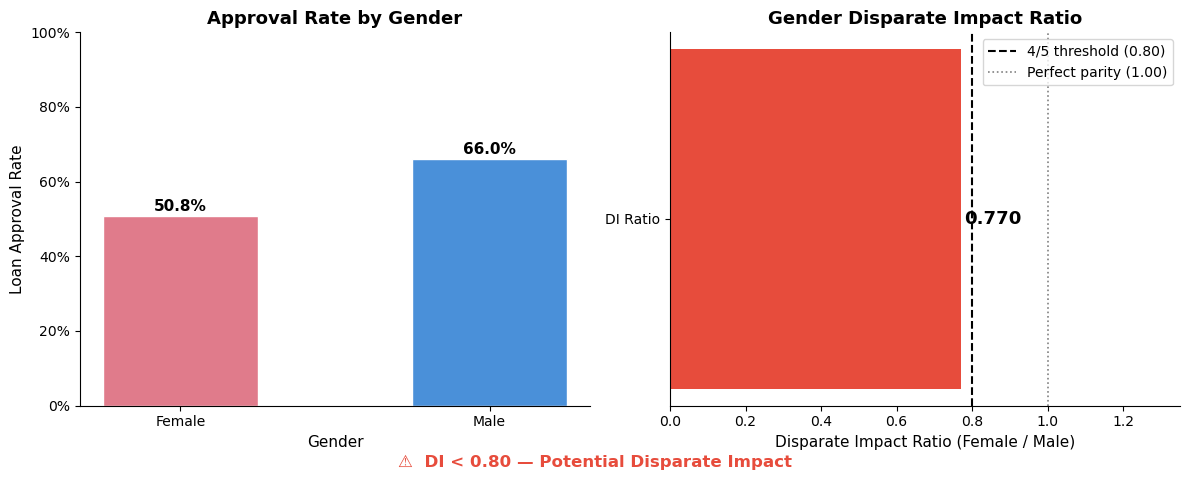

In [8]:
fig = bias.plot_gender_di(gender_tbl, gender_di,
                          save_path=FIGURES_DIR / 'fig1_gender_disparate_impact.png')
print('Saved -> figures/fig1_gender_disparate_impact.png')

## 3. Age-Based Bias Patterns

In [10]:
age_tbl   = bias.age_approval_table(analysis)
age_di_df = bias.age_di_table(analysis)
chi2_age  = bias.chi2_test(bias.age_subset(analysis), 'age_band')

print('Approval rate by age band:')
print(age_tbl.to_string(index=False))
print()
print(f"Chi-sq test (age band vs approved): chi2={chi2_age['chi2']:.3f}, "
      f"p={chi2_age['p_value']:.4f} -> "
      f"{'SIGNIFICANT' if chi2_age['significant_at_05'] else 'not significant'} at alpha=0.05")
print()
print(f"DI ratios vs reference band ('{bias.PRIME_AGE_REFERENCE}'):")
print(age_di_df[['unprivileged_group', 'unprivileged_n', 'unprivileged_rate',
                  'disparate_impact', 'four_fifths_flag']].to_string(index=False))

Approval rate by age band:
age_band   n  approved_n  approval_rate
     <25  13           6         0.4615
   25-34 152          71         0.4671
   35-44 174         114         0.6552
   45-54  87          56         0.6437
   55-64  56          35         0.6250
     65+  13           7         0.5385

Chi-sq test (age band vs approved): chi2=14.752, p=0.0115 -> SIGNIFICANT at alpha=0.05

DI ratios vs reference band ('25-34'):
unprivileged_group  unprivileged_n  unprivileged_rate  disparate_impact  four_fifths_flag
               <25              13             0.4615            0.9881             False
             35-44             174             0.6552            1.4026             False
             45-54              87             0.6437            1.3780             False
             55-64              56             0.6250            1.3380             False
               65+              13             0.5385            1.1528             False


Saved -> figures/fig2_age_approval_rates.png


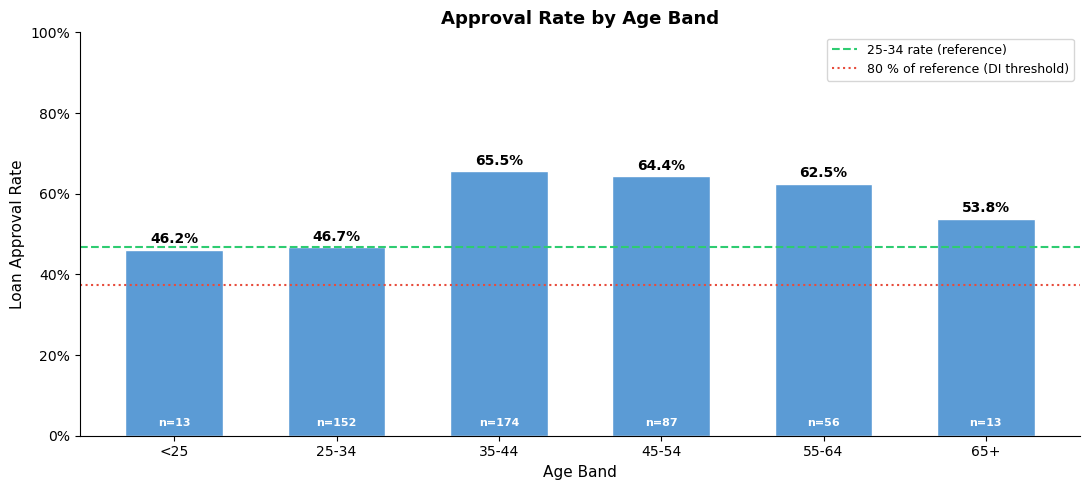

In [12]:
fig = bias.plot_age_approval(age_tbl,
                             save_path=FIGURES_DIR / 'fig2_age_approval_rates.png')
print('Saved -> figures/fig2_age_approval_rates.png')

## 4. Gender x Age Interaction Effects

In [13]:
interaction_tbl = bias.interaction_table(analysis)
print('Approval rate by age band x gender:')
print(interaction_tbl.to_string(index=False))

Approval rate by age band x gender:
age_band clean_gender  n  approved_n  approval_rate
     <25       Female  6           3         0.5000
     <25         Male  7           3         0.4286
   25-34       Female 80          28         0.3500
   25-34         Male 72          43         0.5972
   35-44       Female 83          49         0.5904
   35-44         Male 91          65         0.7143
   45-54       Female 40          25         0.6250
   45-54         Male 46          30         0.6522
   55-64       Female 31          17         0.5484
   55-64         Male 25          18         0.7200
     65+       Female  8           4         0.5000
     65+         Male  5           3         0.6000


Saved -> figures/fig3_gender_age_heatmap.png


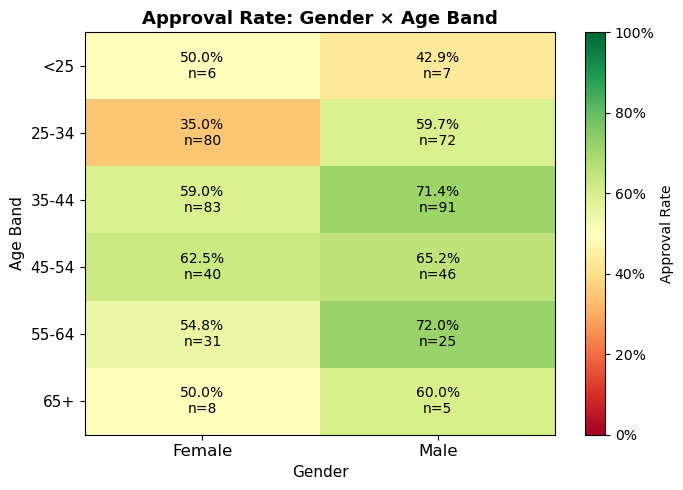

In [14]:
fig = bias.plot_interaction_heatmap(interaction_tbl,
                                    save_path=FIGURES_DIR / 'fig3_gender_age_heatmap.png')
print('Saved -> figures/fig3_gender_age_heatmap.png')

Saved -> figures/fig4_gender_age_grouped_bars.png


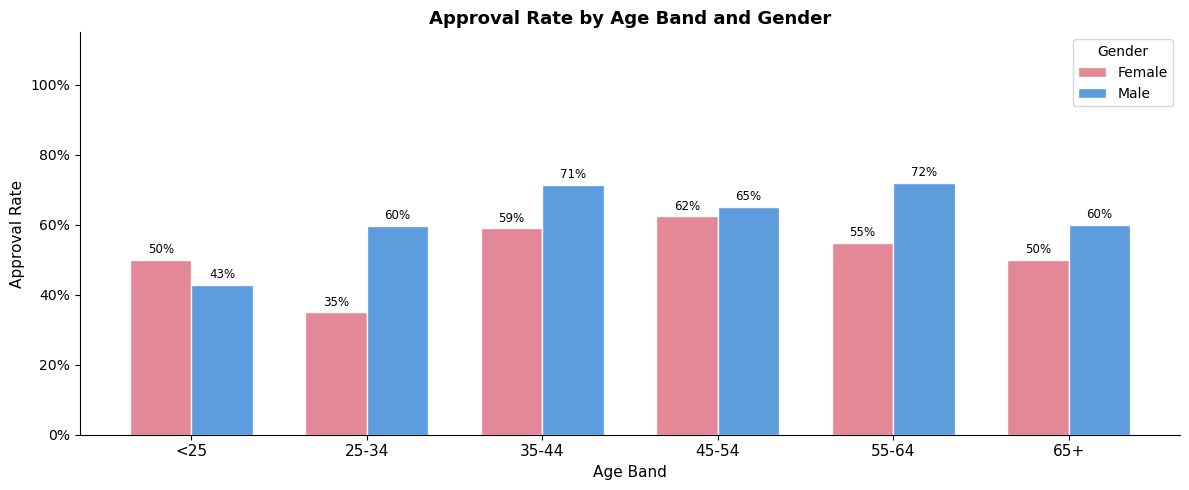

In [15]:
fig = bias.plot_interaction_bars(interaction_tbl,
                                 save_path=FIGURES_DIR / 'fig4_gender_age_grouped_bars.png')
print('Saved -> figures/fig4_gender_age_grouped_bars.png')

## 5. Proxy Discrimination — Financial Features

Non-protected attributes can act as proxies for gender or age. Mann-Whitney U tests check whether financial feature distributions differ significantly between Male and Female applicants.

In [16]:
proxy_tbl = bias.financial_proxy_table(analysis)
print('Financial feature proxy analysis (Male vs Female):')
print(proxy_tbl.to_string(index=False))

Financial feature proxy analysis (Male vs Female):
                    feature  male_median  female_median     u_stat  p_value  significant_at_05
        clean_annual_income   81000.0000     82500.0000 29468.0000   0.3796              False
clean_credit_history_months      48.0000        50.0000 29830.0000   0.6166              False
       clean_debt_to_income       0.2400         0.2200 32594.0000   0.2483              False
      clean_savings_balance   27973.0000     26113.0000 31363.0000   0.7018              False


In [17]:
corr = bias.credit_age_correlation(analysis)
print('Spearman correlation — age band rank vs credit history months:')
print(f"  rho = {corr['spearman_rho']:.4f},  p = {corr['p_value']:.4f}  "
      f"-> {'significant positive correlation' if corr['spearman_rho'] > 0 and corr['significant_at_05'] else 'not significant'}")
print()
print('If approval is sensitive to credit history, this acts as an indirect age proxy.')

Spearman correlation — age band rank vs credit history months:
  rho = 0.6147,  p = 0.0000  -> significant positive correlation

If approval is sensitive to credit history, this acts as an indirect age proxy.


Saved -> figures/fig5_financial_features_by_gender.png


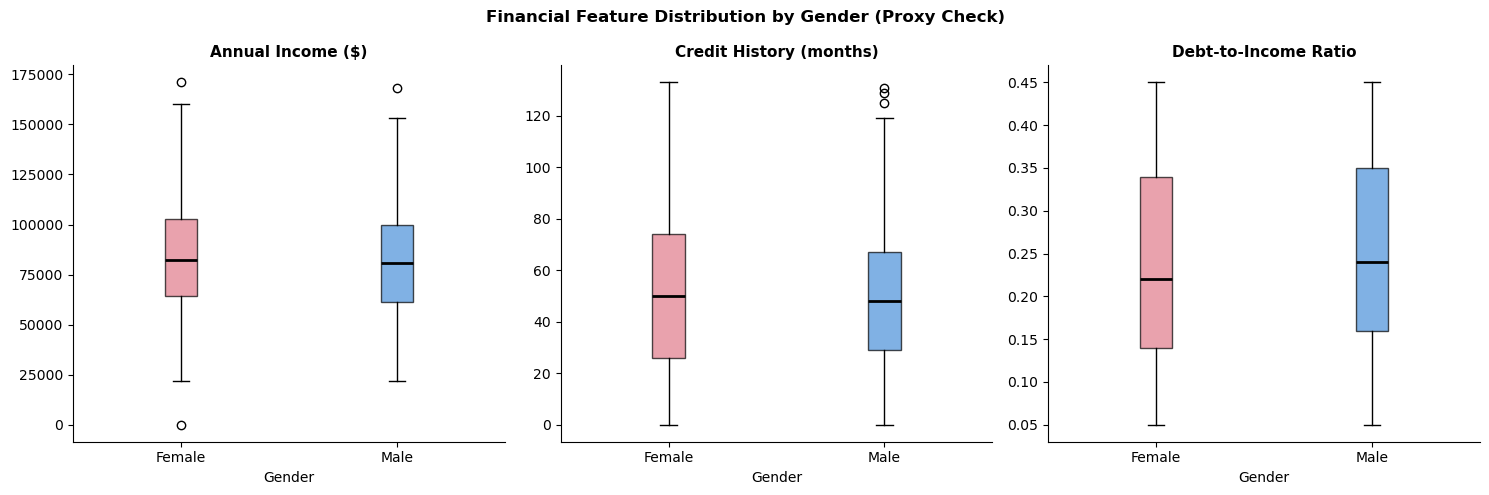

In [18]:
fig = bias.plot_financial_boxplots(analysis,
                                   save_path=FIGURES_DIR / 'fig5_financial_features_by_gender.png')
print('Saved -> figures/fig5_financial_features_by_gender.png')

## 6. Proxy Discrimination — Spending Categories

Spending patterns may encode gendered behaviour. Categories that correlate with gender *and* approval constitute a proxy discrimination channel.

In [19]:
spending_tbl = bias.spending_gender_table(analysis, spending)

if spending_tbl is not None:
    print('Average monthly spending by category and gender:')
    print(spending_tbl)
    print()
    if 'Female' in spending_tbl.index and 'Male' in spending_tbl.index:
        gap = (spending_tbl.loc['Female'] - spending_tbl.loc['Male']).abs().sort_values(ascending=False)
        print('Top categories by gender spending gap:')
        print(gap.head(8))
else:
    print('Spending category data not available.')

Average monthly spending by category and gender:
category_clean  Adult Entertainment  Alcohol   Dining  Education  \
clean_gender                                                       
Female                     322.0000 644.6700 464.1600   507.4900   
Male                       658.5000 414.2500 480.4300   488.9300   

category_clean  Entertainment  Fitness  Gambling  Groceries  Healthcare  \
clean_gender                                                              
Female               510.3100 411.8200  408.1700   499.9600    452.8400   
Male                 466.5300 490.8000    0.0000   479.1800    449.6100   

category_clean  Insurance     Rent  Shopping  Transportation   Travel  \
clean_gender                                                            
Female           492.0000 511.9400  446.1500        392.6500 497.1500   
Male             460.0000 536.4300  472.7300        501.7200 489.8300   

category_clean  Utilities  
clean_gender               
Female           518.6500  


## 7. Interest Rate Disparity (Approved Applicants)

Discrimination can manifest in loan **terms** for approved applicants, not just in approval decisions.

In [20]:
ir_result = bias.interest_rate_by_gender(analysis)

if ir_result:
    print('Interest rate disparity (approved applicants only):')
    print(f"  Male   median: {ir_result['male_median_rate']:.4f}   mean: {ir_result['male_mean_rate']:.4f}   n={ir_result['male_n']}")
    print(f"  Female median: {ir_result['female_median_rate']:.4f}   mean: {ir_result['female_mean_rate']:.4f}   n={ir_result['female_n']}")
    print(f"  Mann-Whitney p: {ir_result['p_value']:.4f}  "
          f"-> {'significant difference' if ir_result['significant_at_05'] else 'no significant difference'}")
else:
    print('Interest rate data not available.')

Interest rate disparity (approved applicants only):
  Male   median: 4.7000   mean: 4.6282   n=163
  Female median: 4.4000   mean: 4.4882   n=127
  Mann-Whitney p: 0.3264  -> no significant difference


C:\Users\madal\Desktop\Mestrado\S2\T1\DEGO\Project\DEGO_Project_Group03\src\bias.py:270: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  approved = gender_subset(df)[df["approved"].eq(1)].copy() if "approved" in df.columns else pd.DataFrame()


Saved -> figures/fig6_interest_rate_by_gender.png


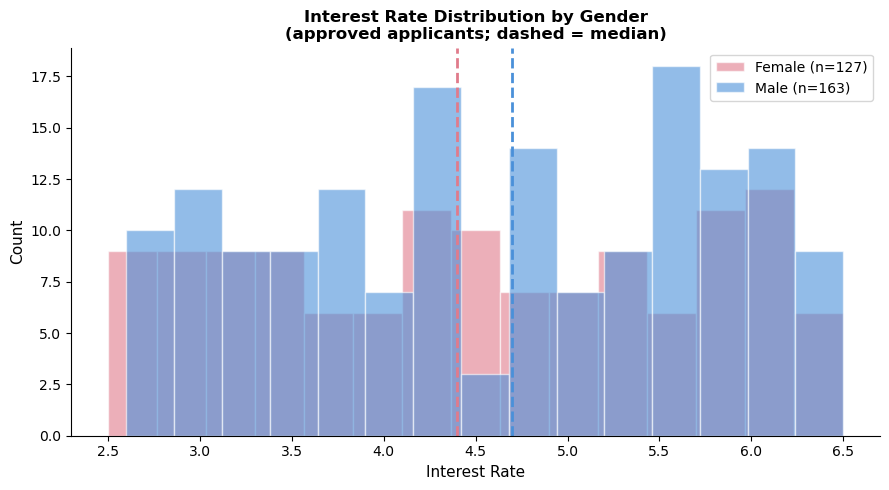

In [21]:
fig = bias.plot_interest_rate(analysis,
                              save_path=FIGURES_DIR / 'fig6_interest_rate_by_gender.png')
print('Saved -> figures/fig6_interest_rate_by_gender.png')

## 8. Rejection Reason Breakdown

In [22]:
rejection_tbl = bias.rejection_reason_by_gender(analysis)

if rejection_tbl is not None:
    print('Rejection reasons by gender (top 15):')
    print(rejection_tbl.head(15))
else:
    print('Rejection reason data not available.')

Rejection reasons by gender (top 15):
clean_gender                 Female  Male  total
clean_rejection_reason                          
algorithm_risk_score            100    69    169
insufficient_credit_history      15     8     23
high_dti_ratio                    7     4     11
low_income                        1     3      4


## 9. Fairness Summary

In [23]:
summary = bias.build_fairness_summary(
    gender_di=gender_di,
    chi2_gender=chi2_gender,
    age_di_df=age_di_df,
    chi2_age=chi2_age,
    ir_result=ir_result,
)

print('FAIRNESS SUMMARY')
print('=' * 100)
print(summary.to_string(index=False))
print('=' * 100)

summary.to_csv(QUALITY_DIR / 'fairness_summary.csv', index=False)
print('\nSaved -> data/quality/fairness_summary.csv')

FAIRNESS SUMMARY
                                  analysis              metric_value four_fifths_flag  p_value  significant_at_05                                       note
           Gender — Disparate Impact Ratio                    0.7698             True   0.0008               True            Female rate 50.8% vs Male 66.0%
    Gender — Demographic Parity Difference                   -0.1519             None   0.0008               True Negative = Female approval rate below Male
             Age — DI ratio (<25 vs 25-34)                    0.9881            False   0.0115               True                                       n=13
           Age — DI ratio (35-44 vs 25-34)                    1.4026            False   0.0115               True                                      n=174
           Age — DI ratio (45-54 vs 25-34)                    1.3780            False   0.0115               True                                       n=87
           Age — DI ratio (55-64 vs 25-34